# **Extract, Transform, Load**

## Objectives

* Fetch data from Kaggle and save as raw data
* Clean and transform data
* Engineer features for modelling
* Validate and document etl process

## Inputs

* data/raw/hotel_bookings.csv
* Supporting Python libraries for data analysis and visualization

## Outputs

* hotel_bookings_clean.csv
* hotel_bookings_sample.csv

## Additional Comments

- All cleaning and transformation steps were documented for transparency and future reproducibility.
- Only relevant columns were retained based on their value to the analysis.
- Outliers reflecting real-world scenarios were kept, not removed.



---

# Change working directory

The notebooks are stored in a subfolder, so to ensure correct file access when running them, the working directory needs to be changed from the notebook’s current folder to its parent folder. This is managed by accessing the current directory using os.getcwd() and then updating it as needed.

In [1]:
import os
current_dir = os.getcwd()
current_dir

'd:\\vscode-projects\\CancelScope-Hotel-Booking-Analysis\\jupyter_notebooks'

To set the parent folder as the working directory, os.path.dirname() is used to obtain the parent directory and os, and chdir() is used to update the current working directory accordingly.

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'd:\\vscode-projects\\CancelScope-Hotel-Booking-Analysis'

# Data understanding, cleaning, preprocessing

Importing neccessary libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import calendar

Read and extract dataset

In [5]:
df = pd.read_csv(os.path.join(current_dir, "data", "raw", "hotel_bookings.csv")) # Read the raw hotel bookings data

The custom "review_dataframe(df)" function is used throughout the project to quickly generate a readable summary of any DataFrame. It prints the overall shape, number of duplicate rows, and for each column, displays the data type, count of missing values, number of unique entries, and a sample of values. This approach is very convenient and presents vital information in a user-friendly format, making it easier to understand the structure and quality of the dataset at a glance.

In [6]:
def review_dataframe(df):
    """
    Prints a summary of the dataframe including shape, duplicate count,
    and for each column: type, missing count, unique count, and sample values. 
    """
    print(f"shape: {df.shape}") # (rows, columns)
    print(f"duplicates: {df.duplicated().sum()}\n") # count of duplicate rows

    print(f"{'column':<30} {'type':<12} {'missing':<8} {'unique':<8} {'sample values'}")
    print("\n")
    for col in df.columns:
        dtype = df[col].dtype
        missing = df[col].isnull().sum()
        unique_count = df[col].nunique(dropna=True)
        sample_values = df[col].dropna().unique()[:5]
        print(f"{col:<30} {str(dtype):<12} {missing:<8} {unique_count:<8} {sample_values}")

Visualise columns and statistics in a read friendly format with the review_dataframe(df) function

In [7]:
review_dataframe(df) # call the function to review the dataframe

shape: (119390, 32)
duplicates: 31994

column                         type         missing  unique   sample values


hotel                          object       0        2        ['Resort Hotel' 'City Hotel']
is_canceled                    int64        0        2        [0 1]
lead_time                      int64        0        479      [342 737   7  13  14]
arrival_date_year              int64        0        3        [2015 2016 2017]
arrival_date_month             object       0        12       ['July' 'August' 'September' 'October' 'November']
arrival_date_week_number       int64        0        53       [27 28 29 30 31]
arrival_date_day_of_month      int64        0        31       [1 2 3 4 5]
stays_in_weekend_nights        int64        0        17       [0 1 2 4 3]
stays_in_week_nights           int64        0        35       [0 1 2 3 4]
adults                         int64        0        14       [ 2  1  3  4 40]
children                       float64      4        5        [ 0. 

Checking for and removing duplicate rows is an important first step to ensure that each record in the dataset is unique, which prevents bias or skewed results during analysis.The shape of the DataFrame is then checked to confirm the number of remaining records.

In [8]:
df = df.drop_duplicates() #remove duplicate rows
df = df.dropna(subset=['children', 'country',]) #remove rows with missing values in children and country columns
df.shape

(86940, 32)

Columns that are redundant, mostly IDs, or not useful for predicting cancellations are dropped to ensure the dataset remains focused, relevant, and free from potential bias.
Columns to drop:
- meal - meal type can often be changed after arrival at the hotel 
- booking_changes - booking changes directly correspond with group booking
- agent - mostly IDs or missing values, and does not provide meaningful predictive information for cancellations
- company - again, mostly IDs or missing values, and is not useful for modeling cancellations
- adr - average revenue earned per day per occupied room,measures pricing and revenue performance, not needed for the current analysis
- required_car_parking_spaces - high correspondance to group visits, could misslead analysis
- total_of_special_requests - high correspondance to group visits, could misslead analysis
- reservation_status - describes a final state of reservation, already captured in is_canceled
- reservation_status_date - records the date when the reservation status was set,it is only known after the booking outcome so it cannot be used for predicting cancellations at the time of booking
- arrival_date_week_number - redundant with arrival_date_month and arrival_date_day_of_month, and does not add predictive value for cancellations

In [9]:
df = df.drop([
    'meal',
    'agent',
    'booking_changes',
    'company',
    'adr',
    'required_car_parking_spaces',
    'total_of_special_requests',
    'reservation_status',
    'reservation_status_date',
    'arrival_date_week_number'
], axis=1)
df.shape # check new shape after dropping columns


(86940, 22)

To assess whether mismatches between reserved and assigned room types contribute significantly to booking cancellations, the dataset is first analyzed to find such cases and calculate their frequency among all cancellations. After determining that only a small proportion of cancellations are associated with room mismatches, both the assigned and reserved room type columns are dropped. This is because assigned room type information is only available after check-in and is not useful for predicting cancellations at the time of booking. Additionally, reserved room type offers limited predictive value in this context and may be redundant with other booking information. Removing these columns simplifies the dataset and ensures that only relevant, pre-arrival features are used for downstream analysis.

In [10]:
cancelled_diff_room_type = df[
    (df['is_canceled'] == 1) & 
    (df['assigned_room_type'] != df['reserved_room_type'])
]
count = cancelled_diff_room_type.shape[0]
print(f"assigned/reserved mismatch: {count}")

assigned/reserved mismatch: 609


Calculate how many canceled bookings involved a mismatch between reserved and assigned room types, and what percentage of total cancellations this represents.

In [11]:
mismatch_canceled = df[(df['is_canceled'] == 1) & (df['reserved_room_type'] != df['assigned_room_type'])].shape[0]
percent_canceled_mismatch = mismatch_canceled / df['is_canceled'].sum() * 100

print(f"mismatched and canceled: {mismatch_canceled}")
print(f"% of total canceled bookings that had a mismatch: {percent_canceled_mismatch:.2f}%")


mismatched and canceled: 609
% of total canceled bookings that had a mismatch: 2.54%


Drop reserved_room_type and assigned_room_type because asigned_room_type is only recorded after check-in so it is not relevant for analysis of pre -arrival data and could introduce inconsistencies. Reserved_room_type provides limited insight for the current analysis and may be redundant with other booking information. Removing both columns simplifies the dataset and ensures only relevant & reliable features are retained for downstream processing. Also, room types are just indicative and do not describe the real room type. Further analysis for that which room is prefered or not cannot be done due to the lack of information regarding the real meaning behind the abreviations.

In [12]:
df = df.drop(['assigned_room_type', 'reserved_room_type'], axis=1)

# New Features

To create a unified and sortable date column, the month names are first mapped to their corresponding two-digit numbers. Then, the day, month, and year columns are combined and converted into a single arrival_date column in datetime format. This makes it easier to analyze and visualize booking trends over time.

In [13]:
# Create a mapping from month name to month number
month_map = {month: str(index).zfill(2) for index, month in enumerate(calendar.month_name) if month}

df['arrival_date'] = pd.to_datetime(
    df['arrival_date_day_of_month'].astype(str).str.zfill(2) + '-' +
    df['arrival_date_month'].map(month_map) + '-' +
    df['arrival_date_year'].astype(str),
    format='%d-%m-%Y',
    dayfirst=True
)

print(df['arrival_date'].nunique()) # verify number of unique values in the column
print(df['arrival_date'].head()) # display first 5

793
0   2015-07-01
1   2015-07-01
2   2015-07-01
3   2015-07-01
4   2015-07-01
Name: arrival_date, dtype: datetime64[ns]


The original day, month, and year columns are not dropped because they may be needed later to extract or engineer additional features from the date information. Keeping these columns ensures flexibility for further analysis.

In [14]:
review_dataframe(df) # review dataframe again to see changes

shape: (86940, 21)
duplicates: 6064

column                         type         missing  unique   sample values


hotel                          object       0        2        ['Resort Hotel' 'City Hotel']
is_canceled                    int64        0        2        [0 1]
lead_time                      int64        0        479      [342 737   7  13  14]
arrival_date_year              int64        0        3        [2015 2016 2017]
arrival_date_month             object       0        12       ['July' 'August' 'September' 'October' 'November']
arrival_date_day_of_month      int64        0        31       [1 2 3 4 5]
stays_in_weekend_nights        int64        0        15       [0 1 2 4 3]
stays_in_week_nights           int64        0        33       [0 1 2 3 4]
adults                         int64        0        14       [ 2  1  3  4 40]
children                       float64      0        5        [ 0.  1.  2. 10.  3.]
babies                         int64        0        5        [ 

Change types:

In [15]:
df['children'] = df['children'].astype(int) # convert float to int
df['is_canceled'] = df['is_canceled'].astype(bool) # convert int to bool
df['is_repeated_guest'] = df['is_repeated_guest'].astype(bool) # convert int to bool

Column names are renamed to shorter, more intuitive labels for clarity and ease of use in analysis (e.g., 'stays_in_weekend_nights' becomes 'weekend_nights').


In [16]:
df = df.rename(columns={
    'stays_in_weekend_nights': 'weekend_nights',
    'stays_in_week_nights': 'week_nights',
    'days_in_waiting_list': 'days_waiting'
})

The next function function standardizes all string columns in the DataFrame by converting text to lowercase and replacing characters like '-', '!', '/', and spaces with underscores. This ensures consistency in column values, making data processing and analysis easier and less error-prone.

In [17]:
def clean_string_columns(df):
    """
    Cleans string columns in the given DataFrame by converting all text to lowercase
    and replacing '-', '!', '/', and spaces with underscores. Only columns with
    object (string) dtype are processed.

    Parameters
    ----------
    df : pandas.DataFrame
        The input DataFrame whose string columns will be cleaned.

    Returns
    -------
    pandas.DataFrame
        The DataFrame with cleaned string columns.
    """
    # Only apply to object (string) columns
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].str.lower().str.replace(r'[-!/ ]', '_', regex=True)
    return df

df = clean_string_columns(df) # clean string columns

New columns are created to better capture key guest and booking characteristics, making the data more meaningful and useful for analysis and modeling.
- total_stay: a single numeric feature  is easier to analyze and model than two separate columns. Total length of stay often correlates with cancellation behaviourand is useful for EDA and models.
- is_family - vallue will be true for bookings with more than one adult and at least one child or baby and false otherwise. Family bookings may have different cancellation patterns and preferences.
- cancellation_ratio: represents the proportion of previous bookings that were canceled.The small value 1e-6 is added to the denominator to avoid division by zero. The column will clarify what fraction of the bookings that a gues made were canceled. For guests with no previous bookings at all (both fields zero), this ratio is zero.If there are many first-time guests with no booking history, then this feature will be zero for them which is logical.

In [18]:
df['total_stay'] = df['weekend_nights'] + df['week_nights'] # total length of stay
df['is_family'] = ((df['adults'] >= 1) & ((df['children'] >= 1) | (df['babies'] >= 1)) & (df['customer_type'] != 'group')) # family booking
df['cancellation_ratio'] = df['previous_cancellations'] / (df['previous_cancellations'] + df['previous_bookings_not_canceled'] + 1e-6) # cancellation ratio
df['total_guests'] = df['adults'] + df['children'] + df['babies'] # total number of guests
df['is_international'] = df['country'] != 'prt' # international booking

- is_international - this column will be very usefull as it will capture the different cacelation rate between domestic and international guests. I keep the countries column as it will be used in the dashboard to visualise map

In [19]:
df = df.drop(['previous_cancellations', 'previous_bookings_not_canceled'], axis=1)
df.shape

(86940, 24)

I decide to analyse deeper if 0 values of the stay_length correspond to canceled reservations, which would be a realistic scenario.
My hypotheseis is that if a reservation is NOT canceled (is_canceled=False) the stay in the hotel must be at least 1 night (stay_length >=1)

In [20]:
not_canceled_zero_stay = df[(df['is_canceled'] == False) & (df['total_stay'] == 0)]
print(f"Rows where reservation was not canceled and stay length is zero: {not_canceled_zero_stay.shape[0]}")


Rows where reservation was not canceled and stay length is zero: 617


The above check shows lack of llogic in a real-world hotel data. A non-canceled reservation should have at least one night. For that reason I decide to remove the 617 rows with not canceled reservations but zero stay length, as they represent some kind of data error.

In [21]:
df = df[~((df['is_canceled'] == False) & (df['total_stay'] == 0))]
df.shape

(86323, 24)

In [22]:
review_dataframe(df) # review dataframe again to see changes

shape: (86323, 24)
duplicates: 6183

column                         type         missing  unique   sample values


hotel                          object       0        2        ['resort_hotel' 'city_hotel']
is_canceled                    bool         0        2        [False  True]
lead_time                      int64        0        478      [ 7 13 14  0  9]
arrival_date_year              int64        0        3        [2015 2016 2017]
arrival_date_month             object       0        12       ['july' 'august' 'september' 'october' 'november']
arrival_date_day_of_month      int64        0        31       [1 2 3 4 5]
weekend_nights                 int64        0        15       [0 1 2 4 3]
week_nights                    int64        0        33       [1 2 3 4 5]
adults                         int64        0        14       [ 1  2  3  4 40]
children                       int32        0        5        [ 0  1  2 10  3]
babies                         int64        0        5        [ 0 

Drop duplicates after creating new features to ensure that any newly created identical rows are also removed, resulting in a clean and reliable dataset for analysis and modeling.

In [23]:
df = df.drop_duplicates()
df.shape

(80140, 24)

# Check and Handle Outliars

I expect that some of the outliars may be true values - large groups or long stays, so I will investigate them further
A boxplot is generated for key numeric columns to visually detect outliers and understand the distribution of each variable. This helps identify unusual values or patterns that may affect the analysis or indicate data quality issues.

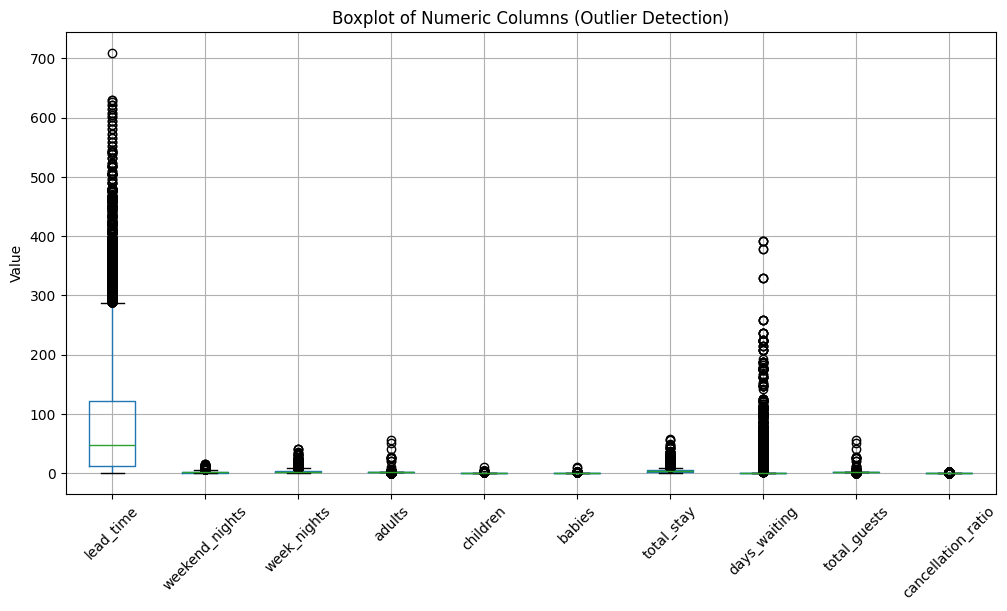

In [24]:
numeric_cols = [
	'lead_time', 'weekend_nights', 'week_nights', 'adults', 'children', 
	'babies', 'total_stay', 'days_waiting', 'total_guests', 'cancellation_ratio'
]

plt.figure(figsize=(12, 6))
df[numeric_cols].boxplot()
plt.title("Boxplot of Numeric Columns (Outlier Detection)")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.show()

For each numeric column, the following code calculates the interquartile range (IQR) and identifies outliers as values that fall below or above 1.5 times the IQR from the first or third quartile. The top 5 outliers for each variable are then printed. This process helps to systematically detect extreme values that may require further investigation or special handling in the analysis.

In [25]:
numeric_cols = [
    'lead_time', 'weekend_nights', 'week_nights', 'adults', 'children', 
    'babies', 'total_stay', 'days_waiting', 'total_guests', 'cancellation_ratio'
]

for col in numeric_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"\nTop 5 outliers for '{col}':")
    print(outliers[[col]].sort_values(by=col, ascending=False).head(5))


Top 5 outliers for 'lead_time':
       lead_time
4182         709
65237        629
65231        629
60173        626
65032        622

Top 5 outliers for 'weekend_nights':
        weekend_nights
33924               16
9839                16
101794              16
54704               14
88017               14

Top 5 outliers for 'week_nights':
        week_nights
101794           41
33924            40
9839             40
88017            35
54704            34

Top 5 outliers for 'adults':
      adults
2173      55
1643      50
1539      40
1962      27
1917      27

Top 5 outliers for 'children':
        children
328           10
18746          3
118200         3
115891         3
92415          3

Top 5 outliers for 'babies':
       babies
46619      10
78656       9
7896        2
39634       2
6719        2

Top 5 outliers for 'total_stay':
        total_stay
101794          57
33924           56
9839            56
88017           49
54704           48

Top 5 outliers for 'days_wait

Below are the rows in the dataset where the number of adults is greater than or equal to 40. Such values may indicate group bookings or potential data entry errors and should be reviewed for validity.

In [26]:
df[df['adults'] >= 40] # investigate outliers in adults column

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,weekend_nights,week_nights,adults,children,...,is_repeated_guest,deposit_type,days_waiting,customer_type,arrival_date,total_stay,is_family,cancellation_ratio,total_guests,is_international
1539,resort_hotel,True,304,2015,september,3,0,3,40,0,...,False,no_deposit,0,group,2015-09-03,3,False,0.0,40,False
1643,resort_hotel,True,336,2015,september,7,1,2,50,0,...,False,no_deposit,0,group,2015-09-07,3,False,0.0,50,False
2173,resort_hotel,True,338,2015,october,4,2,0,55,0,...,False,no_deposit,0,group,2015-10-04,2,False,0.0,55,False


Observation - top 3 outliars are actualy Group bookings, so I consider them valid data.

Rows where the number of children equals 10 are also examined to determine if these are outliers or valid group bookings. If the booking details suggest a school trip, camp, or similar group event, these records are considered plausible and kept in the dataset.

In [27]:
df[df['children'] == 10]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,weekend_nights,week_nights,adults,children,...,is_repeated_guest,deposit_type,days_waiting,customer_type,arrival_date,total_stay,is_family,cancellation_ratio,total_guests,is_international
328,resort_hotel,True,55,2015,july,12,4,10,2,10,...,False,no_deposit,0,contract,2015-07-12,14,True,0.0,12,False


Observation: The combination (2 adults + 10 children, contract booking long stay) strongly suggests a legitimate group booking -school trip, summer camp, tour group. I consider it a valid data.

Now, checking the lead_time - 709, to visualise the booking features:

In [28]:
df[df['lead_time'] == 709]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_day_of_month,weekend_nights,week_nights,adults,children,...,is_repeated_guest,deposit_type,days_waiting,customer_type,arrival_date,total_stay,is_family,cancellation_ratio,total_guests,is_international
4182,resort_hotel,False,709,2016,february,25,8,20,2,0,...,False,no_deposit,0,transient,2016-02-25,28,False,0.0,2,True


The maximum lead_time outlier should be kept in the dataset because it represents a plausible, though rare, real-world scenario: a booking made far in advance, possibly for a special event or personal reason. Additionally, the presence of this outlier does not indicate a data error, as the associated reservation details are consistent and realistic. Also, as there are more reservations made more that a year in advance, I consider this a hotel practice (alowing long lead time for bookings)

Outliers are treated as valid observations and will be retained for further analysis during the EDA and dashboard development stages.

In [29]:
review_dataframe(df) # review dataframe again to see changes

shape: (80140, 24)
duplicates: 0

column                         type         missing  unique   sample values


hotel                          object       0        2        ['resort_hotel' 'city_hotel']
is_canceled                    bool         0        2        [False  True]
lead_time                      int64        0        478      [ 7 13 14  0  9]
arrival_date_year              int64        0        3        [2015 2016 2017]
arrival_date_month             object       0        12       ['july' 'august' 'september' 'october' 'november']
arrival_date_day_of_month      int64        0        31       [1 2 3 4 5]
weekend_nights                 int64        0        15       [0 1 2 4 3]
week_nights                    int64        0        33       [1 2 3 4 5]
adults                         int64        0        14       [ 1  2  3  4 40]
children                       int32        0        5        [ 0  1  2 10  3]
babies                         int64        0        5        [ 0  1 

# Labeling
During the ETL process categorical columns are labeled with human-readable values using predefined mappings. This improves dataset readability, ensures consistency and simplifies downstream analysis, reporting, and visualization. All labeling is generated with Copilot.

In [30]:
#This will create a new column country_label with readable country names.
# Mapping country codes to full country names
country_map = {
    'gbr': 'United Kingdom', 'prt': 'Portugal', 'usa': 'United States', 'esp': 'Spain', 'irl': 'Ireland',
    'fra': 'France', 'rou': 'Romania', 'nor': 'Norway', 'omn': 'Oman', 'arg': 'Argentina',
    'pol': 'Poland', 'deu': 'Germany', 'bel': 'Belgium', 'che': 'Switzerland', 'cn': 'China',
    'grc': 'Greece', 'ita': 'Italy', 'nld': 'Netherlands', 'dnk': 'Denmark', 'rus': 'Russia',
    'swe': 'Sweden', 'aus': 'Australia', 'est': 'Estonia', 'cze': 'Czech Republic', 'bra': 'Brazil',
    'fin': 'Finland', 'moz': 'Mozambique', 'bwa': 'Botswana', 'lux': 'Luxembourg', 'svn': 'Slovenia',
    'alb': 'Albania', 'ind': 'India', 'chn': 'China', 'mex': 'Mexico', 'mar': 'Morocco',
    'ukr': 'Ukraine', 'smr': 'San Marino', 'lva': 'Latvia', 'pri': 'Puerto Rico', 'srb': 'Serbia',
    'chl': 'Chile', 'aut': 'Austria', 'blr': 'Belarus', 'ltu': 'Lithuania', 'tur': 'Turkey',
    'zaf': 'South Africa', 'ago': 'Angola', 'isr': 'Israel', 'cym': 'Cayman Islands', 'zmb': 'Zambia',
    'cpv': 'Cape Verde', 'zwe': 'Zimbabwe', 'dza': 'Algeria', 'kor': 'South Korea', 'cri': 'Costa Rica',
    'hun': 'Hungary', 'are': 'United Arab Emirates', 'tun': 'Tunisia', 'jam': 'Jamaica', 'hrv': 'Croatia',
    'hkg': 'Hong Kong', 'irn': 'Iran', 'geo': 'Georgia', 'and': 'Andorra', 'gib': 'Gibraltar',
    'ury': 'Uruguay', 'jey': 'Jersey', 'caf': 'Central African Republic', 'cyp': 'Cyprus', 'col': 'Colombia',
    'ggy': 'Guernsey', 'kwt': 'Kuwait', 'nga': 'Nigeria', 'mdv': 'Maldives', 'ven': 'Venezuela',
    'svk': 'Slovakia', 'fji': 'Fiji', 'kaz': 'Kazakhstan', 'pak': 'Pakistan', 'idn': 'Indonesia',
    'lbn': 'Lebanon', 'phl': 'Philippines', 'sen': 'Senegal', 'syc': 'Seychelles', 'aze': 'Azerbaijan',
    'bhr': 'Bahrain', 'nzl': 'New Zealand', 'tha': 'Thailand', 'dom': 'Dominican Republic', 'mkd': 'North Macedonia',
    'mys': 'Malaysia', 'arm': 'Armenia', 'jpn': 'Japan', 'lka': 'Sri Lanka', 'cub': 'Cuba',
    'cmr': 'Cameroon', 'bih': 'Bosnia and Herzegovina', 'mus': 'Mauritius', 'com': 'Comoros', 'sur': 'Suriname',
    'uga': 'Uganda', 'bgr': 'Bulgaria', 'civ': "Côte d'Ivoire", 'jor': 'Jordan', 'syr': 'Syria',
    'sgp': 'Singapore', 'bdi': 'Burundi', 'sau': 'Saudi Arabia', 'vnm': 'Vietnam', 'plw': 'Palau',
    'egy': 'Egypt', 'per': 'Peru', 'mlt': 'Malta', 'mwi': 'Malawi', 'ecu': 'Ecuador',
    'mdg': 'Madagascar', 'isl': 'Iceland', 'uzb': 'Uzbekistan', 'npl': 'Nepal', 'bhs': 'Bahamas',
    'mac': 'Macau', 'tgo': 'Togo', 'twn': 'Taiwan', 'dji': 'Djibouti', 'stp': 'São Tomé and Príncipe',
    'kna': 'Saint Kitts and Nevis', 'eth': 'Ethiopia', 'irq': 'Iraq', 'hnd': 'Honduras', 'rwa': 'Rwanda',
    'qat': 'Qatar', 'khm': 'Cambodia', 'mco': 'Monaco', 'bgd': 'Bangladesh', 'imn': 'Isle of Man',
    'tjk': 'Tajikistan', 'nic': 'Nicaragua', 'ben': 'Benin', 'vgb': 'British Virgin Islands', 'tza': 'Tanzania',
    'gab': 'Gabon', 'gha': 'Ghana', 'tmp': 'Timor-Leste', 'glp': 'Guadeloupe', 'ken': 'Kenya',
    'lie': 'Liechtenstein', 'gnb': 'Guinea-Bissau', 'mne': 'Montenegro', 'umi': 'U.S. Minor Outlying Islands',
    'myt': 'Mayotte', 'fro': 'Faroe Islands', 'mmr': 'Myanmar', 'pan': 'Panama', 'bfa': 'Burkina Faso',
    'lby': 'Libya', 'mli': 'Mali', 'nam': 'Namibia', 'bol': 'Bolivia', 'pry': 'Paraguay',
    'brb': 'Barbados', 'abw': 'Aruba', 'aia': 'Anguilla', 'slv': 'El Salvador', 'dma': 'Dominica',
    'pyf': 'French Polynesia', 'guy': 'Guyana', 'lca': 'Saint Lucia', 'ata': 'Antarctica',
    'gtm': 'Guatemala', 'asm': 'American Samoa', 'mrt': 'Mauritania', 'ncl': 'New Caledonia', 'kir': 'Kiribati',
    'sdn': 'Sudan', 'atf': 'French Southern Territories', 'sle': 'Sierra Leone', 'lao': 'Laos'
}

df['country_label'] = df['country'].map(country_map).fillna(df['country']) # Create a new column with full country names, defaulting to original code if not found

# Create readable labels for distribution_channel, customer_type
# Create a readable label for market_segment values
segment_labels = {
    'direct': 'Direct Booking',
    'corporate': 'Corporate Client',
    'online_ta': 'Online Travel Agency',
    'offline_ta_to': 'Offline Travel Agent/Tour Operator',
    'complementary': 'Complimentary Stay',
    'groups': 'Group Booking'
}
df['market_segment_label'] = df['market_segment'].map(segment_labels).fillna(df['market_segment'])

# Create a readable label for distribution_channel values
distribution_channel_labels = {
    'direct': 'Direct Booking',
    'corporate': 'Corporate Channel',
    'ta_to': 'Travel Agent/Tour Operator',
    'undefined': 'Undefined Channel',
    'gds': 'Global Distribution System'
}
df['distribution_channel_label'] = df['distribution_channel'].map(distribution_channel_labels).fillna(df['distribution_channel'])

# Create a readable label for customer_type values
customer_type_labels = {
    'transient': 'Transient Guest',
    'contract': 'Contract Client',
    'transient_party': 'Transient Party',
    'group': 'Group Booking'
}
df['customer_type_label'] = df['customer_type'].map(customer_type_labels).fillna(df['customer_type'])

# Save cleaned file as hotel_bookings_clean.csv

In [31]:
df.to_csv("data/clean/hotel_bookings_clean.csv", index=False)

# Sampling and encoding

In [32]:
review_dataframe(df) # review dataframe again to see changes

shape: (80140, 28)
duplicates: 0

column                         type         missing  unique   sample values


hotel                          object       0        2        ['resort_hotel' 'city_hotel']
is_canceled                    bool         0        2        [False  True]
lead_time                      int64        0        478      [ 7 13 14  0  9]
arrival_date_year              int64        0        3        [2015 2016 2017]
arrival_date_month             object       0        12       ['july' 'august' 'september' 'october' 'november']
arrival_date_day_of_month      int64        0        31       [1 2 3 4 5]
weekend_nights                 int64        0        15       [0 1 2 4 3]
week_nights                    int64        0        33       [1 2 3 4 5]
adults                         int64        0        14       [ 1  2  3  4 40]
children                       int32        0        5        [ 0  1  2 10  3]
babies                         int64        0        5        [ 0  1 

I select columns that include key booking, customer, and reservation details that are relevant for predicting cancellations. These features capture temporal patterns, guest composition, booking behavior, and payment characteristics. Keeping only these columns helps focus the machine learning model on meaningful inputs while removing unrelated information. The target variable is_canceled is included to enable supervised learning.


In [33]:
# Columns to keep for ML
ml_features = [
    'hotel', 'lead_time', 'arrival_date_year', 'arrival_date_month',
    'weekend_nights', 'week_nights',
    'adults', 'children', 'babies',
    'is_international',
    'market_segment', 'distribution_channel', 'deposit_type',
    'days_waiting', 'customer_type', 
    'is_repeated_guest',
    'is_family'
]

# Include target
df_sampled = df[ml_features + ['is_canceled']].copy()

In [34]:
review_dataframe(df_sampled) # review dataframe again to see changes

shape: (80140, 18)
duplicates: 7137

column                         type         missing  unique   sample values


hotel                          object       0        2        ['resort_hotel' 'city_hotel']
lead_time                      int64        0        478      [ 7 13 14  0  9]
arrival_date_year              int64        0        3        [2015 2016 2017]
arrival_date_month             object       0        12       ['july' 'august' 'september' 'october' 'november']
weekend_nights                 int64        0        15       [0 1 2 4 3]
week_nights                    int64        0        33       [1 2 3 4 5]
adults                         int64        0        14       [ 1  2  3  4 40]
children                       int32        0        5        [ 0  1  2 10  3]
babies                         int64        0        5        [ 0  1  2 10  9]
is_international               bool         0        2        [ True False]
market_segment                 object       0        7       

Duplicates appeared again because after selecting only a subset of columns, some rows that were previously unique became identical. In the full dataset, those records differed in other columns that were later removed. Once those distinguishing columns were dropped, the remaining values matched across multiple rows, creating new duplicates. Therefore, it was necessary to remove them again to maintain data integrity before continuing the analysis.

In [35]:
df_sampled = df_sampled.drop_duplicates()
df_sampled.shape

(73003, 18)

If the target variable is imbalanced (for example, 30% canceled and 70% not canceled), it can negatively affect the machine learning model. The model might learn to favor the majority class ("not canceled") because predicting it more often yields higher accuracy, even though it fails to correctly identify cancellations.  
To avoid this bias and improve the model’s ability to detect both outcomes, a balanced dataset (50:50) is used for training. This ensures the model sees an equal number of canceled and non-canceled bookings, helping it learn the distinguishing patterns for both classes.  
However, for evaluation or real-world predictions, it’s recommended to test on data that reflects the original 30:70 distribution, so model performance remains realistic and representative of actual hotel bookings.



In [36]:
print(df_sampled['is_canceled'].value_counts(normalize=True)) # check class balance

is_canceled
False    0.697506
True     0.302494
Name: proportion, dtype: float64


An equal number of samples (50% canceled, 50% not canceled) are randomly selected from each class to ensure that the model learns patterns from both outcomes equally.  
The two subsets are then combined and shuffled, resulting in a balanced dataset of 10,000 records (5,000 from each class).  
This balanced sampling helps prevent model bias toward the majority class and improves its ability to correctly identify cancellations.

In [37]:
# Calculate sample sizes for each class based on 50:50 proportions
n_total = 10000
n_false = n_total // 2
n_true = n_total - n_false

# Randomly sample from each class
df_false = df_sampled[df_sampled['is_canceled'] == False].sample(n=n_false, random_state=42)
df_true = df_sampled[df_sampled['is_canceled'] == True].sample(n=n_true, random_state=42)

# Concatenate and shuffle the final sample
df_sample = pd.concat([df_false, df_true]).sample(frac=1, random_state=42).reset_index(drop=True)
print(df_sample['is_canceled'].value_counts(normalize=True))
df_sample.shape

is_canceled
True     0.5
False    0.5
Name: proportion, dtype: float64


(10000, 18)

Only 10,000 rows were sampled to create a balanced dataset for training. Using a smaller, representative subset helps reduce computation time and memory usage, ensuring the machine learning model trains efficiently without slowing down. Despite the reduced size, the sample is large enough to capture meaningful patterns for predicting cancellations.

In [38]:
review_dataframe(df_sample)

shape: (10000, 18)
duplicates: 0

column                         type         missing  unique   sample values


hotel                          object       0        2        ['city_hotel' 'resort_hotel']
lead_time                      int64        0        405      [173   1  92  17  68]
arrival_date_year              int64        0        3        [2016 2015 2017]
arrival_date_month             object       0        12       ['september' 'december' 'october' 'november' 'march']
weekend_nights                 int64        0        10       [2 0 1 4 5]
week_nights                    int64        0        20       [1 3 2 4 8]
adults                         int64        0        7        [2 3 1 0 4]
children                       int32        0        4        [1 0 2 3]
babies                         int64        0        2        [0 1]
is_international               bool         0        2        [ True False]
market_segment                 object       0        7        ['online_ta' 'dir

Now, I identify all categorical columns in the dataset by selecting columns with data type "object"   
This helps understand the range of categories in the data, detect potential data quality issues (such as typos or inconsistent labels), and prepare the features for machine learning (e.g., encoding them into numerical format).


In [39]:
categorical_cols = df_sample.select_dtypes(include='object').columns.tolist() # identify categorical columns
for col in categorical_cols: # review unique values in each categorical column
    unique_vals = df_sample[col].unique()
    print(f"Column: {col}")
    print(f"Unique values ({len(unique_vals)}): {unique_vals}\n")

Column: hotel
Unique values (2): ['city_hotel' 'resort_hotel']

Column: arrival_date_month
Unique values (12): ['september' 'december' 'october' 'november' 'march' 'august' 'april'
 'june' 'may' 'july' 'january' 'february']

Column: market_segment
Unique values (7): ['online_ta' 'direct' 'complementary' 'offline_ta_to' 'groups' 'corporate'
 'aviation']

Column: distribution_channel
Unique values (4): ['ta_to' 'direct' 'corporate' 'gds']

Column: deposit_type
Unique values (3): ['no_deposit' 'non_refund' 'refundable']

Column: customer_type
Unique values (4): ['transient' 'group' 'transient_party' 'contract']



The next step is to prepare categorical features for machine learning by converting them into numerical representations. The hotel column is encoded as a binary variable, with 0 representing city hotels and 1 representing resort hotels. The arrival_date_month column is mapped from month names to integers (January = 1, February = 2, … December = 12) to capture temporal order. Multi-class categorical columns such as market_segment, distribution_channel, deposit_type, and customer_type are transformed using one-hot encoding, creating separate binary columns for each category while dropping the first category to avoid multicollinearity. These transformations ensure that all categorical features are represented numerically, making them suitable for machine learning algorithms.

In [40]:
# Encode hotel as binary
df_sample['hotel'] = df_sample['hotel'].map({'city_hotel': 0, 'resort_hotel': 1})

# Encode arrival month as integers
month_map = {'january': 1, 'february': 2, 'march': 3, 'april': 4, 'may': 5, 'june': 6,
             'july': 7, 'august': 8, 'september': 9, 'october': 10, 'november': 11, 'december': 12}
df_sample['arrival_date_month'] = df_sample['arrival_date_month'].map(month_map)

# One-hot encode multi-class categorical columns
df_sample = pd.get_dummies(df_sample, columns=['market_segment', 'distribution_channel', 
                                               'deposit_type', 'customer_type'], drop_first=True)

In [41]:
review_dataframe(df_sample) # review dataframe again to see changes

shape: (10000, 28)
duplicates: 0

column                         type         missing  unique   sample values


hotel                          int64        0        2        [0 1]
lead_time                      int64        0        405      [173   1  92  17  68]
arrival_date_year              int64        0        3        [2016 2015 2017]
arrival_date_month             int64        0        12       [ 9 12 10 11  3]
weekend_nights                 int64        0        10       [2 0 1 4 5]
week_nights                    int64        0        20       [1 3 2 4 8]
adults                         int64        0        7        [2 3 1 0 4]
children                       int32        0        4        [1 0 2 3]
babies                         int64        0        2        [0 1]
is_international               bool         0        2        [ True False]
days_waiting                   int64        0        54       [  0  98 207  34  65]
is_repeated_guest              bool         0        2  

Finally - I save the processed dataset to a CSV file named hotel_bookings_sample.csv. At this stage, only categorical features have been encoded (binary and one-hot encoding), while numerical features are kept as-is. This is because the planned machine learning algorithm, Random Forest, can handle raw numerical values directly and does not require scaling or normalization. Encoding categorical features ensures the model can interpret them correctly, while leaving numerical features untouched preserves their original magnitudes and relationships.

In [42]:
df_sample.to_csv("data/clean/hotel_bookings_sample.csv", index=False)

NOTE

* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---